In [1]:
import pandas as pd

In [2]:
df_ground_truth = pd.read_csv('../data_gloss/ground-truth-data.csv')

In [3]:
ground_truth = df_ground_truth.to_dict(orient='records')
ground_truth[0]

{'question': 'What are labels used for in Kubernetes?',
 'title': 'Label',
 'document': 'b021df6a'}

In [4]:
import json

with open('../data_gloss/docs-ids.json', 'rt') as f_in:
    documents = json.load(f_in)

documents[0]

{'title': 'Label',
 'text': 'Tags objects with identifying attributes that are meaningful and relevant to users.\n\n<!--more--> \n\nLabels are key/value pairs that are attached to objects such as . They are used to organize and to select subsets of objects.',
 'source_file': 'label.md',
 'id': 'b021df6a'}

In [5]:
doc_idx = {d['id']: d for d in documents}
doc_idx['b021df6a']['text']

'Tags objects with identifying attributes that are meaningful and relevant to users.\n\n<!--more--> \n\nLabels are key/value pairs that are attached to objects such as . They are used to organize and to select subsets of objects.'

## Indexing with Vector Search

In [117]:
from sentence_transformers import SentenceTransformer

model_name = "intfloat/multilingual-e5-large"
model = SentenceTransformer(model_name)

In [43]:
from tqdm.auto import tqdm

vectors = []

for doc in tqdm(documents):
    title = doc['title']
    text = doc['text']
    vector = model.encode(title + ' ' + text)
    vectors.append(vector)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [01:27<00:00,  2.60it/s]


In [8]:
vectors[2]

array([ 1.80884879e-02, -4.65294812e-03, -3.26536149e-02,  2.57255360e-02,
        3.58658023e-02,  7.05806306e-03,  5.48124984e-02, -2.65196580e-02,
        6.96281791e-02, -2.63482220e-02,  1.39946034e-02, -5.54139912e-02,
       -1.30516263e-02,  3.68059892e-03,  1.25775347e-02, -4.23482098e-02,
        3.28624621e-02,  2.57538874e-02, -7.58771077e-02,  4.20469083e-02,
        1.55477285e-01, -1.52878882e-03, -9.91551727e-02, -1.73584614e-02,
       -3.35005596e-02,  3.69905606e-02, -1.17775925e-01,  1.44982059e-02,
        8.85519013e-02,  6.28353842e-03,  2.48750322e-03,  5.68468124e-02,
        1.14091365e-02,  1.79151408e-02,  9.37679559e-02,  7.96098448e-03,
       -8.69038999e-02, -7.10235834e-02, -2.85339579e-02,  3.81267397e-03,
       -3.07292752e-02,  3.98034491e-02, -7.97804520e-02,  6.80798143e-02,
       -7.41403177e-02,  1.08109424e-02, -7.12156370e-02, -3.72463949e-02,
       -6.07325658e-02,  2.13113278e-02, -4.90776151e-02,  9.16626155e-02,
       -1.24814035e-02, -

In [44]:
import numpy as np

vectors = np.array(vectors)

In [45]:
import faiss

# build FAISS index
dimension = vectors.shape[1]   # length of your embedding vector
index = faiss.IndexFlatL2(dimension)  # L2 distance (or IndexFlatIP for cosine similarity)
index.add(np.array(vectors).astype("float32"))

# keep metadata mapping
documents_map = np.array(documents)

def faiss_vector_search(vector, num_results=5):
    vector = np.array(vector).astype("float32").reshape(1, -1)
    distances, indices = index.search(vector, num_results)

    # filter by course
    results = []
    for i, idx in enumerate(indices[0]):
        results.append({
            "document": documents_map[idx],
            "distance": float(distances[0][i])
        })
    return results

In [46]:
def question_text_vector(q):
    question = q["question"]

    v_q = model.encode(question)
    return faiss_vector_search(v_q)

In [50]:
question_text_vector(dict(
    question='How can I label the pods?'
))

[{'document': {'title': 'kubectl top pod',
   'text': "Display resource (CPU/memory) usage of pods.\n\n The 'top pod' command allows you to see the resource consumption of pods.\n\n Due to the metrics pipeline delay, they may be unavailable for a few minutes since pod creation.\n\n```\nkubectl top pod [NAME | -l label]\n```\n\n```\n  # Show metrics for all pods in the default namespace\n  kubectl top pod\n  \n  # Show metrics for all pods in the given namespace\n  kubectl top pod --namespace=NAMESPACE\n  \n  # Show metrics for a given pod and its containers\n  kubectl top pod POD_NAME --containers\n  \n  # Show metrics for the pods defined by label name=myLabel\n  kubectl top pod -l name=myLabel\n```",
   'source_file': 'kubectl_top_pod.md',
   'id': '24d99e73'},
  'distance': 0.33841532468795776},
 {'document': {'title': 'PodTemplate',
   'text': "An API object that defines a template for creating .\nThe PodTemplate API is also embedded in API definitions for workload management, such

In [67]:
def build_prompt(query, search_results):
    prompt_template = """
You are a Kubernetes assistant. Use ONLY the information in the "context" to answer the user's question.

REQUIREMENTS:
- Output ONLY raw Markdown text (no surrounding quotes, no JSON, no markdown in a string).
- Use literal line breaks for paragraphs and fenced code blocks for commands (```bash ... ```).
- Do NOT include backslash-n sequences ("\n") to indicate newlines — use real newlines.
- Do not escape code blocks or wrap them in a string.
- Return the answer only (no meta commentary).

Example of desired output:
To apply a YAML file in Kubernetes, use the following command:

```bash
kubectl apply -f FILENAME.yaml

Context:
{context}

User's Question:
{question}

Answer:
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"title: {doc['document']['title']}\nanswer: {doc['document']['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [68]:
from openai import OpenAI

In [69]:
client = OpenAI()

In [74]:
def llm(prompt, model='gpt-4o'):
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [75]:
# previously: rag(query: str) -> str
def rag(query: dict, model='gpt-4o') -> str:
    search_results = question_text_vector(query)
    
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [76]:
ground_truth[1]

{'question': 'In what ways can a LimitRange restrict resources for containers or Pods?',
 'title': 'LimitRange',
 'document': '0ad333e2'}

In [77]:
rag(ground_truth[10])

'A LimitRange either limits the quantity of resources that can be created for a particular resource type, or the amount of resources that may be requested/consumed by individual containers or Pods within a namespace.'

In [78]:
doc_idx['0ad333e2']['text']

'Constraints resource consumption per  or ,\nspecified for a particular .\n\n<!--more--> \n\nA [LimitRange](/docs/concepts/policy/limit-range/) either limits the quantity of \nthat can be created (for a particular resource type),\nor the amount of \nthat may be requested/consumed by individual containers or Pods within a namespace.'

## Cosine similarity metric

In [79]:
answer_orig = 'Constraints resource consumption per  or ,\nspecified for a particular .\n\n<!--more--> \n\nA [LimitRange](/docs/concepts/policy/limit-range/) either limits the quantity of \nthat can be created (for a particular resource type),\nor the amount of \nthat may be requested/consumed by individual containers or Pods within a namespace.'
answer_llm = 'A LimitRange either limits the quantity of resources that can be created for a particular resource type, or the amount of resources that may be requested/consumed by individual containers or Pods within a namespace.'

v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

v_llm.dot(v_orig)

0.9561522

In [80]:
ground_truth[0]

{'question': 'What are labels used for in Kubernetes?',
 'title': 'Label',
 'document': 'b021df6a'}

In [83]:
len(ground_truth)

944

In [84]:
answers = {}

In [88]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'title': rec['title'],
    }

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 944/944 [00:15<00:00, 61.87it/s]


In [89]:
len(answers)

944

In [90]:
results_gpt4o = [None] * len(ground_truth)

for i, val in answers.items():
    results_gpt4o[i] = val.copy()
    results_gpt4o[i].update(ground_truth[i])

In [91]:
import pandas as pd

In [92]:
df_gpt4o = pd.DataFrame(results_gpt4o)

In [135]:
df_gpt4o

,answer_llm,answer_orig,document,question,title
0,Labels in Kubernetes are used to tag objects w...,Tags objects with identifying attributes that ...,b021df6a,What are labels used for in Kubernetes?,Label
1,A label key and value in Kubernetes must begin...,Tags objects with identifying attributes that ...,b021df6a,How are labels structured in Kubernetes?,Label
2,Labels are key/value pairs that are attached t...,Tags objects with identifying attributes that ...,b021df6a,What is the role of key/value pairs in labelin...,Label
3,Labels are meaningful and relevant to users be...,Tags objects with identifying attributes that ...,b021df6a,Why might users find labels meaningful and rel...,Label
4,"In Kubernetes, labels can be attached to a var...",Tags objects with identifying attributes that ...,b021df6a,Which Kubernetes objects can have labels attac...,Label
...,...,...,...,...,...
939,JSON and YAML formats are accepted.,Apply a configuration to a resource by file na...,8666ad26,What are the file formats accepted for applyin...,kubectl apply
940,"Before using the 'apply' command, ensure that ...",Apply a configuration to a resource by file na...,8666ad26,What should you do before using the 'apply' co...,kubectl apply
941,To apply a configuration stored in a specific ...,Apply a configuration to a resource by file na...,8666ad26,How can you apply a configuration stored in a ...,kubectl apply
942,The purpose of the --prune flag when applying ...,Apply a configuration to a resource by file na...,8666ad26,What is the purpose of the --prune flag when a...,kubectl apply


In [93]:
df_gpt4o.to_csv('../data_gloss/results-gpt4o.csv', index=False)

## Evaluating GPT 3.5

In [94]:
rag(ground_truth[10], model='gpt-3.5-turbo')

'A LimitRange can restrict resources for containers or Pods by either limiting the quantity of resources that can be created (for a particular resource type), or by limiting the amount of resources that may be requested or consumed by individual containers or Pods within a namespace.'

In [95]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=6)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [100]:
def process_record(rec):
    model = 'gpt-3.5-turbo'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'title': rec['title'],
    }

In [102]:
process_record(ground_truth[10])

{'answer_llm': 'A LimitRange can restrict resources for containers or Pods by:\n\n- Limiting the quantity of that can be created for a particular resource type.\n- Restricting the amount of resources that may be requested or consumed by individual containers or Pods within a namespace.',
 'answer_orig': 'Constraints resource consumption per  or ,\nspecified for a particular .\n\n<!--more--> \n\nA [LimitRange](/docs/concepts/policy/limit-range/) either limits the quantity of \nthat can be created (for a particular resource type),\nor the amount of \nthat may be requested/consumed by individual containers or Pods within a namespace.',
 'document': '0ad333e2',
 'question': 'In what ways can a LimitRange restrict resources for containers or Pods?',
 'title': 'LimitRange'}

In [109]:
answers_gpt35 = {}

In [120]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers_gpt35:
        continue

    llm_model = "gpt-3.5-turbo"
    answer_llm = rag(rec, model=llm_model)

    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers_gpt35[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'title': rec['title'],
    }

  0%|                                                                                                                        | 0/944 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

 77%|███████████████████████████████████████████████████████████████████████████████████▋                         | 725/944 [00:01<00:00, 392.06it/s]

725
726
727
728
729
730
731
732
733
734
735


 78%|█████████████████████████████████████████████████████████████████████████████████████▊                        | 736/944 [00:13<00:05, 41.57it/s]

736


 78%|█████████████████████████████████████████████████████████████████████████████████████▉                        | 737/944 [00:14<00:05, 35.79it/s]

737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753


 80%|███████████████████████████████████████████████████████████████████████████████████████▊                      | 754/944 [00:33<00:18, 10.22it/s]

754


 80%|███████████████████████████████████████████████████████████████████████████████████████▉                      | 755/944 [00:34<00:19,  9.76it/s]

755
756
757
758
759
760
761
762
763


 81%|█████████████████████████████████████████████████████████████████████████████████████████                     | 764/944 [00:50<00:36,  4.93it/s]

764


 81%|█████████████████████████████████████████████████████████████████████████████████████████▏                    | 765/944 [00:52<00:39,  4.56it/s]

765
766
767
768
769
770


 82%|█████████████████████████████████████████████████████████████████████████████████████████▊                    | 771/944 [01:01<00:55,  3.10it/s]

771
772
773
774


 82%|██████████████████████████████████████████████████████████████████████████████████████████▎                   | 775/944 [01:06<01:07,  2.51it/s]

775
776
777


 82%|██████████████████████████████████████████████████████████████████████████████████████████▋                   | 778/944 [01:11<01:19,  2.09it/s]

778
779


 83%|██████████████████████████████████████████████████████████████████████████████████████████▉                   | 780/944 [01:14<01:30,  1.81it/s]

780
781


 83%|███████████████████████████████████████████████████████████████████████████████████████████                   | 782/944 [01:16<01:34,  1.72it/s]

782


 83%|███████████████████████████████████████████████████████████████████████████████████████████▏                  | 783/944 [01:17<01:37,  1.65it/s]

783


 83%|███████████████████████████████████████████████████████████████████████████████████████████▎                  | 784/944 [01:21<02:07,  1.26it/s]

784


 83%|███████████████████████████████████████████████████████████████████████████████████████████▍                  | 785/944 [01:23<02:37,  1.01it/s]

785


 83%|███████████████████████████████████████████████████████████████████████████████████████████▌                  | 786/944 [01:26<03:03,  1.16s/it]

786


 83%|███████████████████████████████████████████████████████████████████████████████████████████▋                  | 787/944 [01:27<03:07,  1.19s/it]

787


 83%|███████████████████████████████████████████████████████████████████████████████████████████▊                  | 788/944 [01:28<03:03,  1.18s/it]

788


 84%|███████████████████████████████████████████████████████████████████████████████████████████▉                  | 789/944 [01:29<02:47,  1.08s/it]

789


 84%|████████████████████████████████████████████████████████████████████████████████████████████                  | 790/944 [01:32<03:36,  1.41s/it]

790


 84%|████████████████████████████████████████████████████████████████████████████████████████████▏                 | 791/944 [01:36<05:13,  2.05s/it]

791


 84%|████████████████████████████████████████████████████████████████████████████████████████████▎                 | 792/944 [01:38<05:03,  2.00s/it]

792


 84%|████████████████████████████████████████████████████████████████████████████████████████████▍                 | 793/944 [01:39<04:47,  1.90s/it]

793


 84%|████████████████████████████████████████████████████████████████████████████████████████████▌                 | 794/944 [01:45<07:32,  3.01s/it]

794


 84%|████████████████████████████████████████████████████████████████████████████████████████████▋                 | 795/944 [01:48<07:35,  3.05s/it]

795


 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                 | 796/944 [01:50<06:50,  2.77s/it]

796


 84%|████████████████████████████████████████████████████████████████████████████████████████████▊                 | 797/944 [01:52<05:45,  2.35s/it]

797


 85%|████████████████████████████████████████████████████████████████████████████████████████████▉                 | 798/944 [01:53<04:50,  1.99s/it]

798


 85%|█████████████████████████████████████████████████████████████████████████████████████████████                 | 799/944 [01:56<05:21,  2.22s/it]

799


 85%|█████████████████████████████████████████████████████████████████████████████████████████████▏                | 800/944 [01:57<04:54,  2.05s/it]

800


 85%|█████████████████████████████████████████████████████████████████████████████████████████████▎                | 801/944 [01:58<04:17,  1.80s/it]

801


 85%|█████████████████████████████████████████████████████████████████████████████████████████████▍                | 802/944 [02:00<03:51,  1.63s/it]

802


 85%|█████████████████████████████████████████████████████████████████████████████████████████████▌                | 803/944 [02:00<03:15,  1.39s/it]

803


 85%|█████████████████████████████████████████████████████████████████████████████████████████████▋                | 804/944 [02:05<05:37,  2.41s/it]

804


 85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                | 805/944 [02:08<05:59,  2.59s/it]

805


 85%|█████████████████████████████████████████████████████████████████████████████████████████████▉                | 806/944 [02:10<05:17,  2.30s/it]

806


 85%|██████████████████████████████████████████████████████████████████████████████████████████████                | 807/944 [02:11<04:35,  2.01s/it]

807


 86%|██████████████████████████████████████████████████████████████████████████████████████████████▏               | 808/944 [02:13<04:04,  1.80s/it]

808


 86%|██████████████████████████████████████████████████████████████████████████████████████████████▎               | 809/944 [02:15<04:34,  2.03s/it]

809


 86%|██████████████████████████████████████████████████████████████████████████████████████████████▍               | 810/944 [02:17<04:07,  1.85s/it]

810


 86%|██████████████████████████████████████████████████████████████████████████████████████████████▌               | 811/944 [02:18<03:53,  1.76s/it]

811


 86%|██████████████████████████████████████████████████████████████████████████████████████████████▌               | 812/944 [02:19<03:15,  1.48s/it]

812


 86%|██████████████████████████████████████████████████████████████████████████████████████████████▋               | 813/944 [02:21<03:31,  1.61s/it]

813


 86%|██████████████████████████████████████████████████████████████████████████████████████████████▊               | 814/944 [02:22<02:58,  1.38s/it]

814


 86%|██████████████████████████████████████████████████████████████████████████████████████████████▉               | 815/944 [02:23<02:47,  1.30s/it]

815


 86%|███████████████████████████████████████████████████████████████████████████████████████████████               | 816/944 [02:25<03:03,  1.43s/it]

816


 87%|███████████████████████████████████████████████████████████████████████████████████████████████▏              | 817/944 [02:26<03:04,  1.46s/it]

817


 87%|███████████████████████████████████████████████████████████████████████████████████████████████▎              | 818/944 [02:27<02:59,  1.43s/it]

818


 87%|███████████████████████████████████████████████████████████████████████████████████████████████▍              | 819/944 [02:30<03:49,  1.84s/it]

819


 87%|███████████████████████████████████████████████████████████████████████████████████████████████▌              | 820/944 [02:32<03:39,  1.77s/it]

820


 87%|███████████████████████████████████████████████████████████████████████████████████████████████▋              | 821/944 [02:35<04:29,  2.19s/it]

821


 87%|███████████████████████████████████████████████████████████████████████████████████████████████▊              | 822/944 [02:36<03:48,  1.87s/it]

822


 87%|███████████████████████████████████████████████████████████████████████████████████████████████▉              | 823/944 [02:39<04:11,  2.08s/it]

823


 87%|████████████████████████████████████████████████████████████████████████████████████████████████              | 824/944 [02:40<03:57,  1.98s/it]

824


 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏             | 825/944 [02:46<05:47,  2.92s/it]

825


 88%|████████████████████████████████████████████████████████████████████████████████████████████████▎             | 826/944 [02:47<04:59,  2.54s/it]

826


 88%|████████████████████████████████████████████████████████████████████████████████████████████████▎             | 827/944 [02:50<04:51,  2.49s/it]

827


 88%|████████████████████████████████████████████████████████████████████████████████████████████████▍             | 828/944 [02:53<05:15,  2.72s/it]

828


 88%|████████████████████████████████████████████████████████████████████████████████████████████████▌             | 829/944 [02:54<04:10,  2.18s/it]

829


 88%|████████████████████████████████████████████████████████████████████████████████████████████████▋             | 830/944 [02:57<04:34,  2.41s/it]

830


 88%|████████████████████████████████████████████████████████████████████████████████████████████████▊             | 831/944 [02:59<04:38,  2.46s/it]

831


 88%|████████████████████████████████████████████████████████████████████████████████████████████████▉             | 832/944 [03:01<04:18,  2.31s/it]

832


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████             | 833/944 [03:02<03:24,  1.85s/it]

833


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏            | 834/944 [03:05<03:51,  2.11s/it]

834


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▎            | 835/944 [03:07<04:03,  2.23s/it]

835


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▍            | 836/944 [03:08<03:17,  1.83s/it]

836


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▌            | 837/944 [03:09<02:52,  1.62s/it]

837


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▋            | 838/944 [03:10<02:21,  1.33s/it]

838


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▊            | 839/944 [03:11<02:10,  1.24s/it]

839


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▉            | 840/944 [03:16<03:54,  2.25s/it]

840


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▉            | 841/944 [03:16<03:10,  1.85s/it]

841


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████            | 842/944 [03:18<02:46,  1.63s/it]

842


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▏           | 843/944 [03:20<03:13,  1.92s/it]

843


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎           | 844/944 [03:21<02:49,  1.70s/it]

844


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▍           | 845/944 [03:23<02:54,  1.77s/it]

845


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▌           | 846/944 [03:26<03:33,  2.17s/it]

846


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▋           | 847/944 [03:30<04:27,  2.75s/it]

847


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▊           | 848/944 [03:31<03:34,  2.23s/it]

848


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▉           | 849/944 [03:33<02:57,  1.87s/it]

849


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████           | 850/944 [03:35<03:18,  2.11s/it]

850


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▏          | 851/944 [03:39<04:11,  2.70s/it]

851


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎          | 852/944 [03:41<03:33,  2.32s/it]

852


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▍          | 853/944 [03:42<03:01,  2.00s/it]

853


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▌          | 854/944 [03:46<03:50,  2.56s/it]

854


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▋          | 855/944 [03:48<03:29,  2.35s/it]

855


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▋          | 856/944 [03:52<04:18,  2.93s/it]

856


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▊          | 857/944 [03:54<03:44,  2.58s/it]

857


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▉          | 858/944 [03:55<02:59,  2.09s/it]

858


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████          | 859/944 [03:56<02:50,  2.01s/it]

859


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 860/944 [04:00<03:28,  2.48s/it]

860


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 861/944 [04:04<04:04,  2.95s/it]

861


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 862/944 [04:05<03:17,  2.41s/it]

862


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 863/944 [04:10<04:01,  2.98s/it]

863


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 864/944 [04:13<04:20,  3.26s/it]

864


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 865/944 [04:17<04:25,  3.35s/it]

865


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 866/944 [04:20<04:13,  3.25s/it]

866


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████         | 867/944 [04:21<03:20,  2.60s/it]

867


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 868/944 [04:22<02:40,  2.11s/it]

868


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 869/944 [04:27<03:31,  2.82s/it]

869


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 870/944 [04:33<04:55,  4.00s/it]

870


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 871/944 [04:35<03:55,  3.23s/it]

871


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 872/944 [04:37<03:38,  3.03s/it]

872


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 873/944 [04:40<03:22,  2.86s/it]

873


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 874/944 [04:43<03:37,  3.11s/it]

874


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 875/944 [04:45<02:55,  2.54s/it]

875


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████        | 876/944 [04:48<02:59,  2.64s/it]

876


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 877/944 [04:49<02:24,  2.16s/it]

877


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 878/944 [04:52<02:55,  2.66s/it]

878


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 879/944 [04:56<03:04,  2.84s/it]

879


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 880/944 [04:57<02:36,  2.44s/it]

880


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 881/944 [05:01<02:57,  2.81s/it]

881


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 882/944 [05:03<02:47,  2.71s/it]

882


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 883/944 [05:10<03:48,  3.75s/it]

883


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████       | 884/944 [05:13<03:39,  3.66s/it]

884


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 885/944 [05:14<02:46,  2.82s/it]

885


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 886/944 [05:16<02:32,  2.64s/it]

886


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 887/944 [05:18<02:23,  2.52s/it]

887


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 888/944 [05:21<02:20,  2.50s/it]

888


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 889/944 [05:22<01:51,  2.03s/it]

889


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 890/944 [05:23<01:33,  1.73s/it]

890


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 891/944 [05:25<01:39,  1.88s/it]

891


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 892/944 [05:26<01:24,  1.62s/it]

892


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████      | 893/944 [05:29<01:41,  2.00s/it]

893


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 894/944 [05:31<01:39,  1.98s/it]

894


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 895/944 [05:34<01:54,  2.34s/it]

895


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 896/944 [05:36<01:43,  2.16s/it]

896


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 897/944 [05:37<01:24,  1.79s/it]

897


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 898/944 [05:38<01:10,  1.53s/it]

898


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 899/944 [05:39<01:06,  1.47s/it]

899


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 900/944 [05:41<01:08,  1.55s/it]

900


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 901/944 [05:43<01:13,  1.70s/it]

901


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████     | 902/944 [05:44<01:01,  1.47s/it]

902


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 903/944 [05:48<01:31,  2.22s/it]

903


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 904/944 [05:49<01:15,  1.89s/it]

904


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 905/944 [05:50<01:07,  1.72s/it]

905


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 906/944 [05:51<00:56,  1.48s/it]

906


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 907/944 [05:53<01:03,  1.73s/it]

907


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 908/944 [05:55<01:03,  1.77s/it]

908


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 909/944 [05:58<01:09,  1.99s/it]

909


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████    | 910/944 [05:59<00:57,  1.70s/it]

910


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 911/944 [06:00<00:48,  1.46s/it]

911


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 912/944 [06:03<01:01,  1.92s/it]

912


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 913/944 [06:04<00:53,  1.74s/it]

913


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 914/944 [06:09<01:27,  2.91s/it]

914


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 915/944 [06:11<01:14,  2.56s/it]

915


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 916/944 [06:13<01:01,  2.19s/it]

916


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 917/944 [06:14<00:51,  1.92s/it]

917


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 918/944 [06:16<00:48,  1.85s/it]

918


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████   | 919/944 [06:17<00:46,  1.84s/it]

919


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 920/944 [06:19<00:39,  1.66s/it]

920


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 921/944 [06:20<00:39,  1.72s/it]

921


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 922/944 [06:21<00:31,  1.45s/it]

922


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 923/944 [06:22<00:26,  1.28s/it]

923


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 924/944 [06:26<00:40,  2.02s/it]

924


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 925/944 [06:28<00:35,  1.89s/it]

925


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 926/944 [06:30<00:39,  2.19s/it]

926


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 927/944 [06:32<00:35,  2.08s/it]

927


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 928/944 [06:35<00:35,  2.20s/it]

928


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 929/944 [06:38<00:39,  2.64s/it]

929


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 930/944 [06:43<00:44,  3.17s/it]

930


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 931/944 [06:47<00:43,  3.36s/it]

931


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 932/944 [06:48<00:32,  2.75s/it]

932


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 933/944 [06:51<00:32,  2.94s/it]

933


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 934/944 [06:55<00:32,  3.29s/it]

934


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 935/944 [06:56<00:23,  2.59s/it]

935


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 936/944 [07:00<00:22,  2.84s/it]

936


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 937/944 [07:02<00:19,  2.75s/it]

937


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 938/944 [07:04<00:15,  2.52s/it]

938


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 939/944 [07:11<00:18,  3.70s/it]

939


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 940/944 [07:12<00:11,  2.87s/it]

940


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 941/944 [07:14<00:08,  2.67s/it]

941


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 942/944 [07:15<00:04,  2.18s/it]

942


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 943/944 [07:17<00:02,  2.27s/it]

943


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 944/944 [07:21<00:00,  2.14it/s]


In [121]:
len(answers_gpt35)

944

In [132]:
answers_gpt35[22]

{'answer_llm': 'Reviewers contribute to the software development process by reviewing code for quality and correctness on some part of the project. They are knowledgeable about both the codebase and software engineering principles, ensuring the integrity and quality of the code being contributed.',
 'answer_orig': 'A person who reviews code for quality and correctness on some part of the project.\n\n<!--more--> \n\nReviewers are knowledgeable about both the codebase and software engineering principles. Reviewer status is scoped to a part of the codebase.',
 'document': '8e58cd87',
 'question': 'How do reviewers contribute to the software development process?',
 'title': 'Reviewer'}

In [175]:
results_gpt35 = [None] * len(ground_truth)

for i, val in answers_gpt35.items():
    results_gpt35[i] = val.copy()
    results_gpt35[i].update(ground_truth[i])

In [176]:
df_gpt35 = pd.DataFrame(results_gpt35)
df_gpt35.to_csv('../data_gloss/results-gpt35.csv', index=False)

In [177]:
!head ../data_gloss/results-gpt35.csv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


answer_llm,answer_orig,document,question,title
Labels in Kubernetes are tags used to attach identifying attributes to objects that are meaningful and relevant to users. They are key/value pairs that help organize objects and select subsets of objects within a Kubernetes cluster.,"Tags objects with identifying attributes that are meaningful and relevant to users.

<!--more--> 

Labels are key/value pairs that are attached to objects such as . They are used to organize and to select subsets of objects.",b021df6a,What are labels used for in Kubernetes?,Label
"In Kubernetes, a label key and value must begin with a letter or number, and may contain letters, numbers, hyphens, dots, and underscores, up to 63 characters each. Optionally, the key can begin with a DNS subdomain prefix and a single '/', like example.com/my-app. If --overwrite is true, then existing labels can be overwritten; otherwise, attempting to overwrite a label will result in an error. If --resource-version is specified, th

### Cosine Similarity

### gpt-4o

In [171]:
results_gpt4o = df_gpt4o.to_dict(orient='records')

In [172]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [173]:
similarity = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 944/944 [04:47<00:00,  3.29it/s]


In [174]:
df_gpt4o['cosine'] = similarity
df_gpt4o['cosine'].describe()

count    944.000000
mean       0.918553
std        0.047847
min        0.721664
25%        0.893284
50%        0.923178
75%        0.951719
max        1.000000
Name: cosine, dtype: float64

### gpt-3.5-turbo

In [178]:
results_gpt35 = df_gpt35.to_dict(orient='records')

similarity_35 = []

for record in tqdm(results_gpt35):
    sim = compute_similarity(record)
    similarity_35.append(sim)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 944/944 [05:14<00:00,  3.00it/s]


In [179]:
df_gpt35['cosine'] = similarity_35
df_gpt35['cosine'].describe()

count    944.000000
mean       0.918736
std        0.048098
min        0.713541
25%        0.893274
50%        0.924423
75%        0.951172
max        0.999111
Name: cosine, dtype: float64

In [180]:
import seaborn as sns
import matplotlib.pyplot as plt

/var/folders/x1/0r7y2h8j4c52sbjgqxwc9m5c0000gn/T/ipykernel_68598/4245021150.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label='4o')
/var/folders/x1/0r7y2h8j4c52sbjgqxwc9m5c0000gn/T/ipykernel_68598/4245021150.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt35

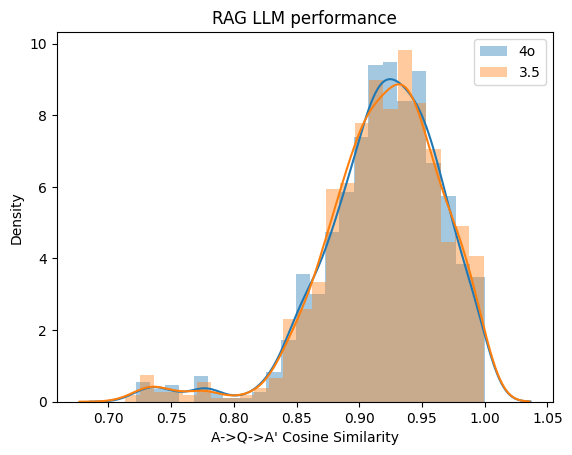

In [181]:
sns.distplot(df_gpt4o['cosine'], label='4o')
sns.distplot(df_gpt35['cosine'], label='3.5')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

## LLM-as-a-Judge

In [182]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [183]:
df_sample = df_gpt4o.sample(n=150, random_state=1)

In [184]:
samples = df_sample.to_dict(orient='records')

In [185]:
record = samples[0]
record

{'answer_llm': 'To ensure the output of a service creation is in JSON format, you can use the `-o json` flag with the `kubectl create service` command. Here is an example:\n\n```bash\nkubectl create service [SERVICE_TYPE] [SERVICE_NAME] --dry-run=client -o json\n```\n\nReplace `[SERVICE_TYPE]` and `[SERVICE_NAME]` with the appropriate service type and name you wish to create. The `--dry-run=client` flag is used to not actually create the service but to show the output in JSON format.',
 'answer_orig': 'Create a service using a specified subcommand.\n\n```\nkubectl create service [flags]\n```',
 'document': '8ef67423',
 'question': 'How can you ensure the output of a service creation is in JSON format?',
 'title': 'kubectl create service',
 'cosine': 0.902371346950531}

In [186]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: Create a service using a specified subcommand.

```
kubectl create service [flags]
```
Generated Question: How can you ensure the output of a service creation is in JSON format?
Generated Answer: To ensure the output of a service creation is in JSON format, you can use the `-o json` flag with the `kubectl create service` command. Here is an example:

```bash
kubectl create service [SERVICE_TYPE] [SERVICE_NAME] --dry-run=client -o json
```

Replace `[SERVICE_TYPE]` and `[SERVICE_NAME]` with the appropriate service type and name you wish to create. The `--dry-run=client` flag is used to not actually 

In [187]:
answer = llm(prompt, model='gpt-4o')

In [188]:
answer

'{\n  "Relevance": "PARTLY_RELEVANT",\n  "Explanation": "The generated answer provides additional information related to the `kubectl create service` command, specifically regarding formatting the output in JSON using flags. While it is relevant to the `kubectl create service` command mentioned in the original answer, it does not directly address the primary intent of the original answer, which is focused on creating a service using a specified subcommand without emphasis on output formatting."\n}'

In [189]:
import json

In [190]:
evaluations = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o')
    evaluations.append(evaluation)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [04:39<00:00,  1.86s/it]


In [191]:
len(df_gpt4o)


944

In [192]:
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [193]:
df_evaluations = pd.DataFrame(json_evaluations)

In [194]:
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           109
PARTLY_RELEVANT     38
NON_RELEVANT         3
Name: count, dtype: int64

In [195]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT'] #.to_dict(orient='records')

,Relevance,Explanation
55,NON_RELEVANT,The generated answer incorrectly describes how...
63,NON_RELEVANT,The generated answer discusses disruptions and...
128,NON_RELEVANT,The generated answer focuses on explaining the...


In [197]:
samples[55]

{'answer_llm': 'To specify which attributes of a fetched resource should be displayed using a template, you can use the `kubectl get` command with the `-o custom-columns` option. This allows you to define custom columns and specify the fields you want to display.\n\n```bash\nkubectl get TYPE NAME -o custom-columns=<COLUMN_SPEC>\n```\n\nReplace `<COLUMN_SPEC>` with your custom definitions to display specific attributes.',
 'answer_orig': 'Display one or many resources.\n\n Prints a table of the most important information about the specified resources. You can filter the list using a label selector and the --selector flag. If the desired resource type is namespaced you will only see results in the current namespace if you don\'t specify any namespace.\n\n By specifying the output as \'template\' and providing a Go template as the value of the --template flag, you can filter the attributes of the fetched resources.\n\nUse "kubectl api-resources" for a complete list of supported resources.

In [198]:
prompt = prompt2_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: What is an example of a situation where a watch would be more efficient than polling in Kubernetes?
Generated Answer: A watch would be more efficient than polling in a situation where a component needs to know whenever a ConfigMap has changed. Using a watch allows for efficient detection of changes by providing changes as a stream, rather than repeatedly checking (polling) for changes at intervals.

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief e

In [199]:
evaluation = llm(prompt, model='gpt-4o')
print(evaluation)

{
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer effectively addresses the question by providing a specific example where watch is more efficient than polling in Kubernetes. It describes a scenario involving a ConfigMap, highlighting the efficiency of using a watch for detecting changes, which aligns with the requirements of the question."
}


In [200]:
evaluations_2 = []

for record in tqdm(samples):
    prompt = prompt2_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o')
    evaluations_2.append(evaluation)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [05:04<00:00,  2.03s/it]


In [201]:
json_evaluations_2 = []

for i, str_eval in enumerate(evaluations_2):
    json_eval = json.loads(str_eval)
    json_evaluations_2.append(json_eval)

In [202]:
df_evaluations_2 = pd.DataFrame(json_evaluations_2)

In [203]:
df_evaluations_2.Relevance.value_counts()

Relevance
RELEVANT           102
PARTLY_RELEVANT     42
NON_RELEVANT         6
Name: count, dtype: int64

In [204]:
df_evaluations_2[df_evaluations_2.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
51,NON_RELEVANT,The proposed command 'kubectl get pods -A -o=c...
61,NON_RELEVANT,The generated answer suggests using 'kubectl c...
63,NON_RELEVANT,The generated answer discusses 'disruptions' a...
89,NON_RELEVANT,"The generated answer mentions key, value, and ..."
99,NON_RELEVANT,The generated answer incorrectly suggests usin...
119,NON_RELEVANT,The generated answer states that 'Drivers' cre...


In [205]:
samples[51]

{'answer_llm': "To display all metadata fields for pods in every namespace, regardless of their specific names, use the following command:\n\n```bash\nkubectl get pods -A -o=custom-columns='DATA:metadata.*'\n```",
 'answer_orig': '```bash\n# All images running in a cluster\nkubectl get pods -A -o=custom-columns=\'DATA:spec.containers[*].image\'\n\n# All images running in namespace: default, grouped by Pod\nkubectl get pods --namespace default --output=custom-columns="NAME:.metadata.name,IMAGE:.spec.containers[*].image"\n\n # All images excluding "registry.k8s.io/coredns:1.6.2"\nkubectl get pods -A -o=custom-columns=\'DATA:spec.containers[?(@.image!="registry.k8s.io/coredns:1.6.2")].image\'\n\n# All fields under metadata regardless of name\nkubectl get pods -A -o=custom-columns=\'DATA:metadata.*\'\n```\n\nMore examples in the kubectl [reference documentation](/docs/reference/kubectl/#custom-columns).',
 'document': '03465c70',
 'question': 'How would you display all metadata fields for 

### Saving all the data

In [206]:
df_gpt4o.to_csv('../data_gloss/results-gpt4o-cosine.csv', index=False)
df_gpt35.to_csv('../data_gloss/results-gpt35-cosine.csv', index=False)

In [207]:
df_evaluations.to_csv('../data_gloss/evaluations-aqa.csv', index=False)
df_evaluations_2.to_csv('../data_gloss/evaluations-qa.csv', index=False)